In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# 📁 Load the Mall Customers dataset
data = pd.read_csv("Mall_Customers.csv")
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# 🔍 Identify numeric and non-numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns

non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns

In [ ]:
# 🧹 Fill missing values in numeric columns with mean (if any)
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())




# 🏷️ Encode categorical columns (e.g., Gender) into numeric using LabelEncoder
label_encoder = LabelEncoder()
for column in non_numeric_columns:
    data[column] = label_encoder.fit_transform(data[column].astype(str))


In [ ]:
# 🎯 Select relevant features for clustering
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = data[features]

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

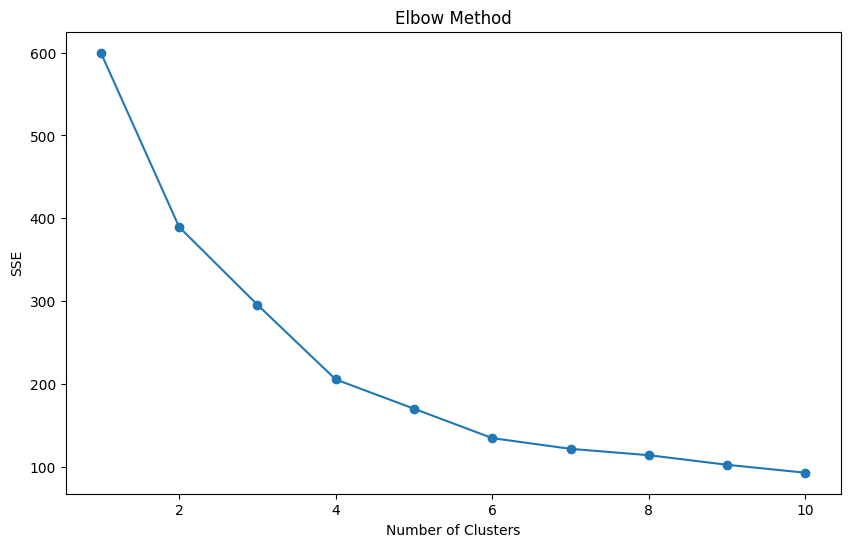

In [ ]:
# 🔍 Finding optimal number of clusters using ELBOW METHOD

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)



plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()


In [59]:

def gap_statistic(X, refs=10, max_clusters=10):
    gaps = []
    sse_refs = []
    sse_orig = []
    shape = X.shape

    for k in range(1, max_clusters + 1):
        # Fit KMeans on original data
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        orig_inertia = kmeans.inertia_
        sse_orig.append(orig_inertia)

        # Fit KMeans on reference (random uniform) datasets
        ref_inertias = []
        for _ in range(refs):
            random_data = np.random.uniform(low=np.min(X, axis=0),
                                            high=np.max(X, axis=0),
                                            size=shape)
            kmeans_ref = KMeans(n_clusters=k, random_state=42)
            kmeans_ref.fit(random_data)
            ref_inertias.append(kmeans_ref.inertia_)

        # Compute Gap Statistic for this K
        gap = np.log(np.mean(ref_inertias)) - np.log(orig_inertia)
        gaps.append(gap)

    # Optimal K is where gap is maximum
    optimal_k = np.argmax(gaps) + 1  # +1 because index starts at 0
    return gaps, optimal_k

# Run Gap Statistic on your scaled data (X_scaled)
gaps, optimal_k = gap_statistic(X_scaled, refs=10, max_clusters=10)


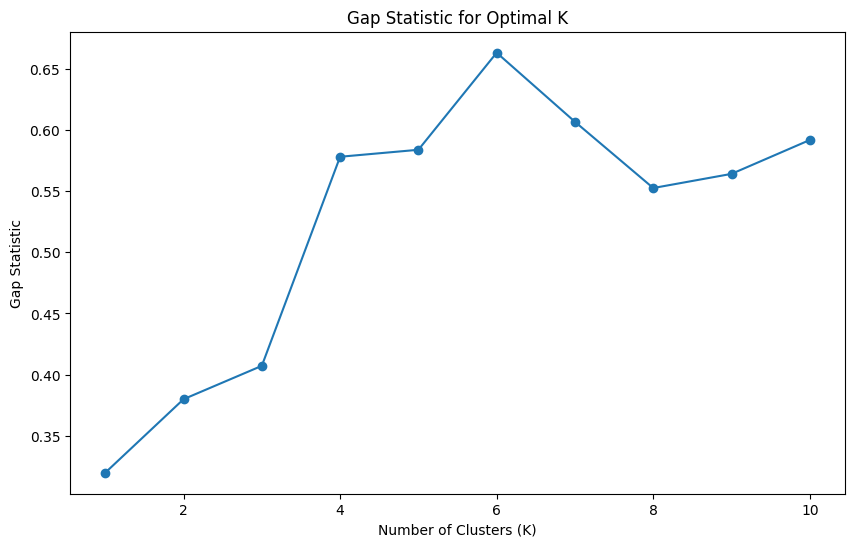

Optimal number of clusters based on Gap Statistic: 6


In [60]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), gaps, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic for Optimal K')
plt.show()

print(f"Optimal number of clusters based on Gap Statistic: {optimal_k}")

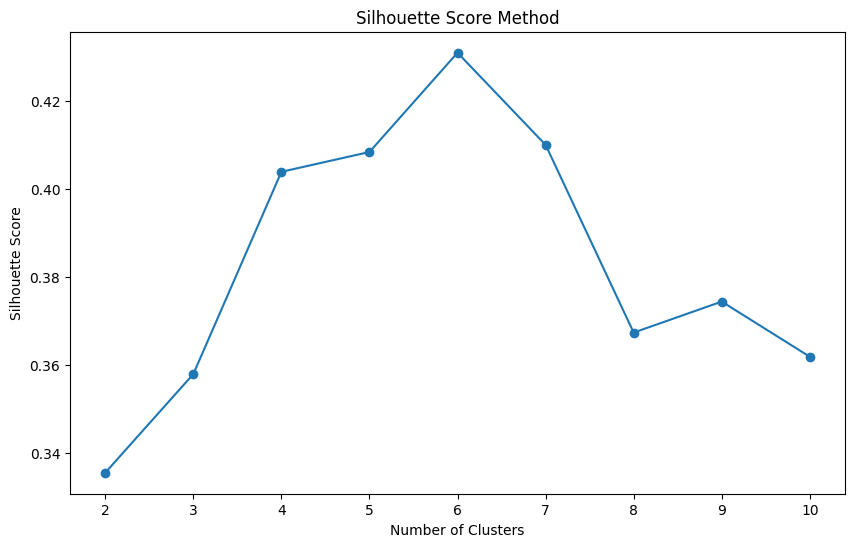

Optimal number of clusters based on silhouette_score : 6


In [ ]:
# 🔍 Finding optimal number of clusters using Silhouette Score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))


# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')

plt.show()
print(f"Optimal number of clusters based on silhouette_score : {optimal_k}")

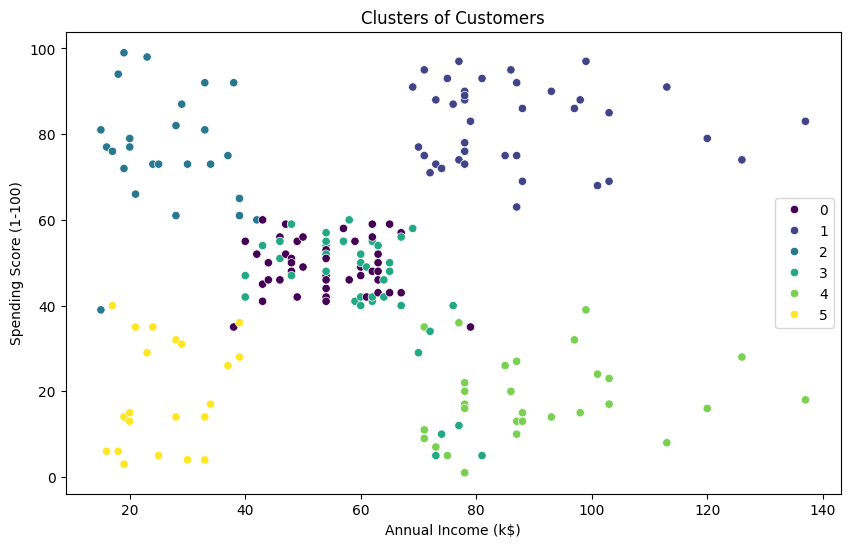

In [ ]:
# ✅ Fit KMeans with chosen optimal number of clusters (example: K=5)
# Using the optimal number of clusters from the elbow method gap statistic or silhouette score

optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)



plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis')
plt.title('Clusters of Customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

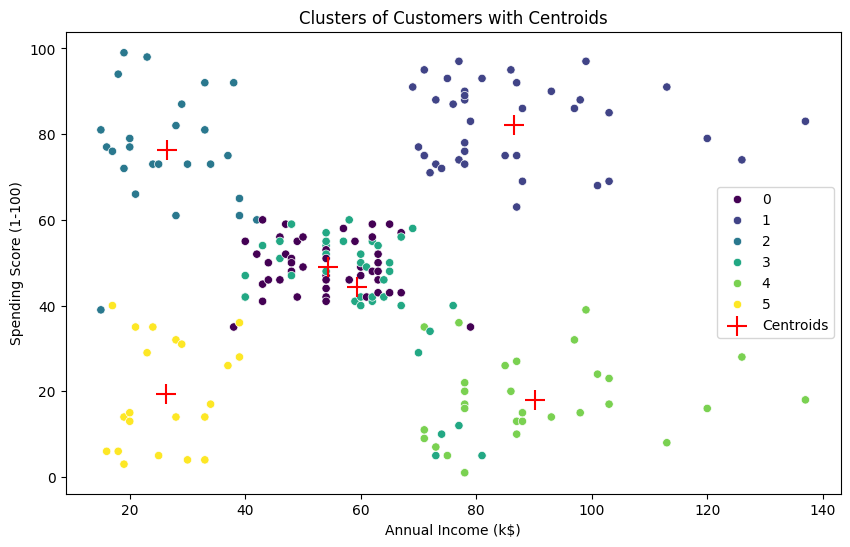

In [70]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)
cluster_centers_df['Cluster'] = range(optimal_k)


plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis')
plt.scatter(cluster_centers_df['Annual Income (k$)'], cluster_centers_df['Spending Score (1-100)'],
            s=200, c='red', marker='+', label='Centroids')
plt.title('Clusters of Customers with Centroids')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()



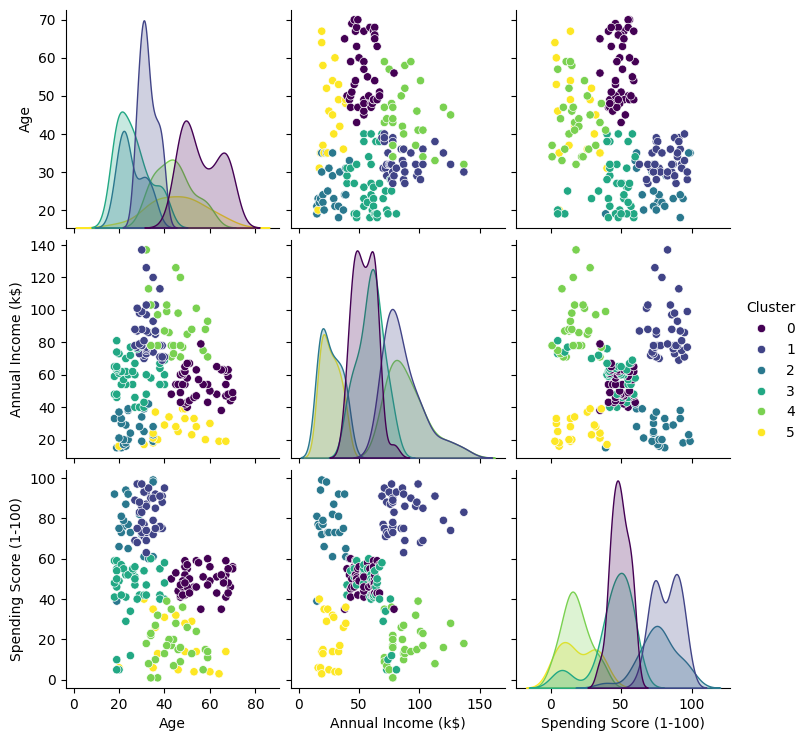

In [64]:
sns.pairplot(data, hue='Cluster', palette='viridis', vars=features)
plt.show()


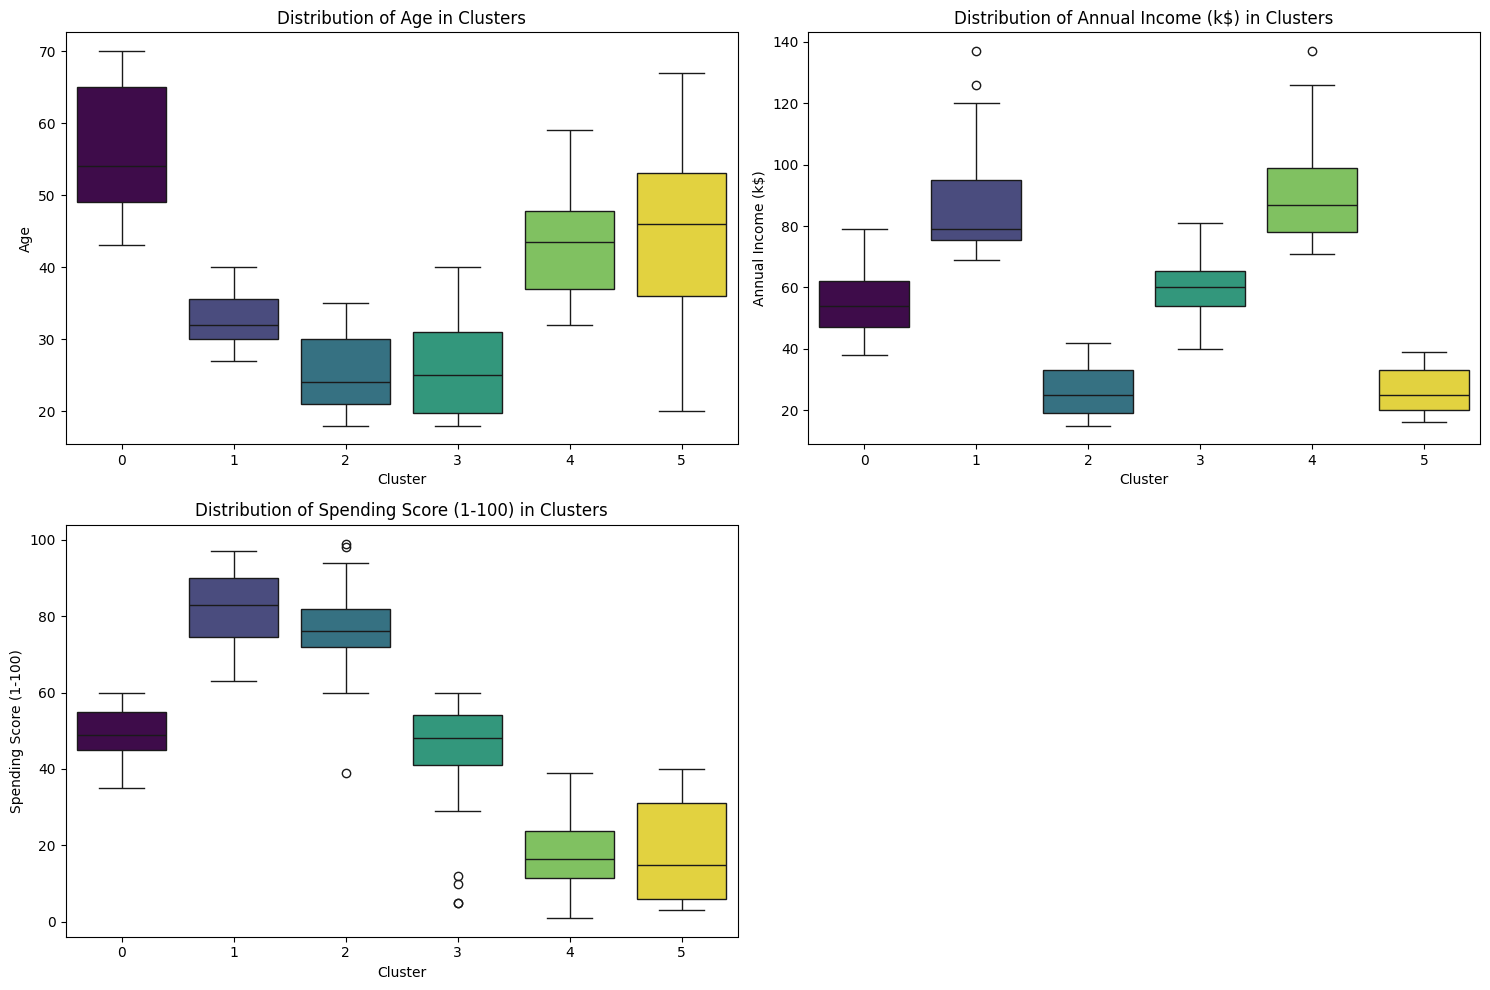

In [65]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Cluster', y=feature, data=data, hue='Cluster', palette='viridis', legend=False)
    plt.title(f'Distribution of {feature} in Clusters')
plt.tight_layout()
plt.show()

In [71]:
cluster_summary = data.groupby('Cluster')[features].mean().reset_index()
print(cluster_summary)

# Save the clustered data
data.to_csv('groupedcustomers.csv', index=False)

   Cluster        Age  Annual Income (k$)  Spending Score (1-100)
0        0  56.333333           54.266667               49.066667
1        1  32.692308           86.538462               82.128205
2        2  25.560000           26.480000               76.240000
3        3  26.125000           59.425000               44.450000
4        4  44.000000           90.133333               17.933333
5        5  45.523810           26.285714               19.380952
